In [17]:
import sys
import pandas as pd
from insurance_analytics.core.registry import settings
from insurance_analytics.hypothesis.metrics import claim_frequency, margin, claim_severity, attach_metrics
from insurance_analytics.hypothesis.segmentation import split_control_test
from insurance_analytics.hypothesis.balance_checks import check_balance
from insurance_analytics.hypothesis.statistical_tests import run_hypothesis_tests
from insurance_analytics.hypothesis.interpert import hypothesis_summary_generator
from insurance_analytics.viz.ab_plots import (
    plot_claim_frequency_by_feature,
    plot_claim_severity_box_by_feature,
    plot_margin_box_by_feature,
    plot_top_zipcode_frequency
)



In [15]:
name = "insurance_cleaned.csv"
processed_path = settings.DATA["processed_dir"] / name
report_path = settings.REPORTS["reports_dir"]
plots_dir = settings.REPORTS["plots_dir"]

# Load data with error handling
try:
    df = pd.read_csv(processed_path, sep=",")
    print(
        f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print(f"Error: File not found at {processed_path}")
    sys.exit(1)
except ValueError as e:
    print(f"Error loading data: {e}")
    sys.exit(1)
except Exception as e:
    print(f"Unexpected error: {e}")
    sys.exit(1)

C:\Users\user\AppData\Local\Temp\ipykernel_10596\2225260617.py:8: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(processed_path, sep=",")


Data loaded successfully: 1000098 rows, 50 columns


In [3]:
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,LegalType,Title,Language,Bank,AccountType,MaritalStatus,...,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,LossRatio
0,145249,12827,1425168000000000000,True,Close Corporation,Mr,English,First National Bank,Current account,Not specified,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0
1,145249,12827,1430438400000000000,True,Close Corporation,Mr,English,First National Bank,Current account,Not specified,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0
2,145249,12827,1435708800000000000,True,Close Corporation,Mr,English,First National Bank,Current account,Not specified,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,NaN
3,145255,12827,1430438400000000000,True,Close Corporation,Mr,English,First National Bank,Current account,Not specified,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,0.0
4,145255,12827,1435708800000000000,True,Close Corporation,Mr,English,First National Bank,Current account,Not specified,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,NaN


In [4]:
claim_frequency(df)

0          0
1          0
2          0
3          0
4          0
          ..
1000093    0
1000094    0
1000095    0
1000096    0
1000097    0
Name: ClaimFrequency, Length: 1000098, dtype: int64

In [5]:
claim_severity(df)

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1000093   NaN
1000094   NaN
1000095   NaN
1000096   NaN
1000097   NaN
Name: ClaimSeverity, Length: 1000098, dtype: float64

In [6]:
margin(df)

0           21.929825
1           21.929825
2            0.000000
3          512.848070
4            0.000000
              ...    
1000093    347.235175
1000094    347.235175
1000095    347.235175
1000096      2.315000
1000097      2.315000
Name: Margin, Length: 1000098, dtype: float64

In [19]:
df = attach_metrics(df)
# df[['ClaimFrequency', 'ClaimSeverity', 'Margin']].head()

In [8]:
control_group, test_group = split_control_test(
    df, feature="Gender", group_a_values="Male", group_b_values="Female")

print(f"Control group size: {len(control_group)}")
print(f"Test group size: {len(test_group)}")

Control group size: 42817
Test group size: 6755


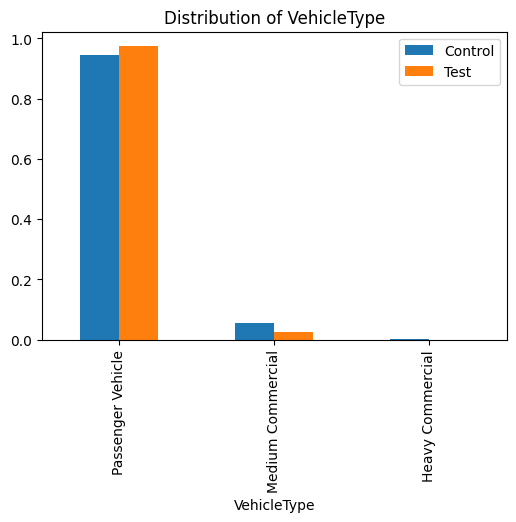

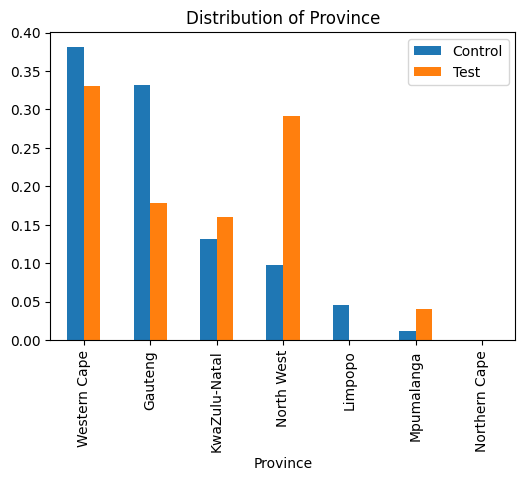

       feature         type  chi2  p_value  balanced
0  VehicleType  categorical   NaN      NaN     False
1     Province  categorical   NaN      NaN     False


In [9]:
confounders = [
    'VehicleType',
    'Province'
]

balance_df = check_balance(control_group, test_group, confounders, plot=True)
print(balance_df)

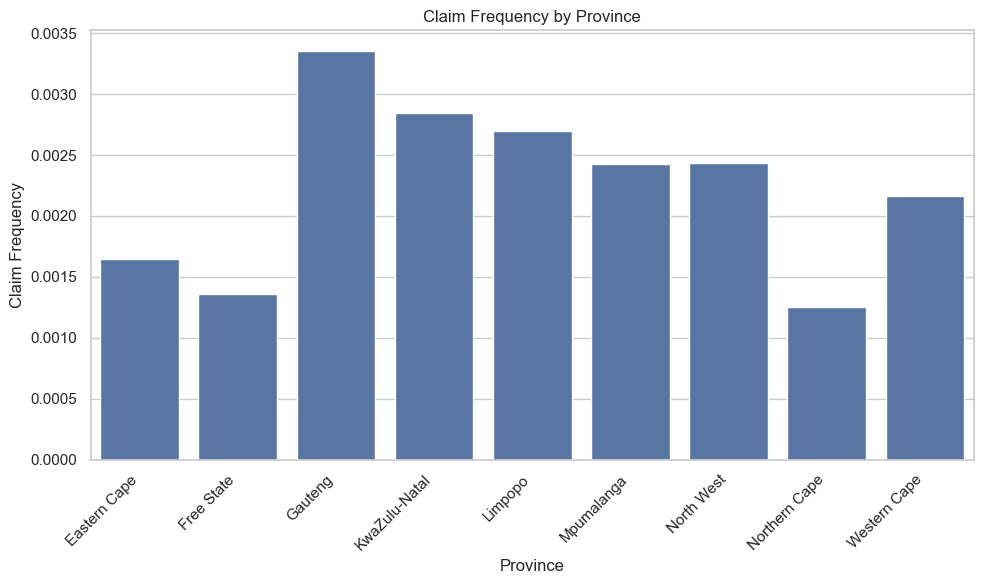

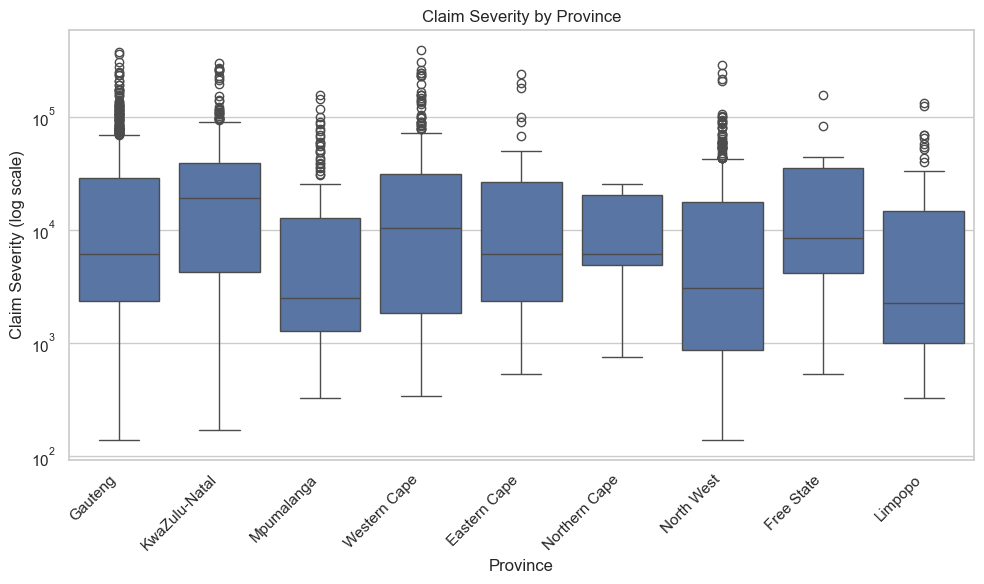

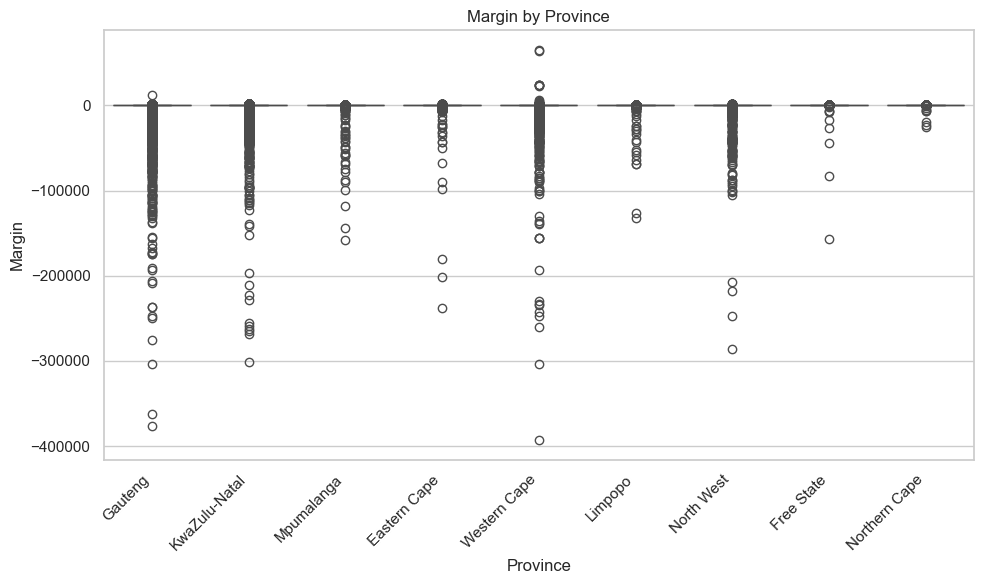

In [20]:
# Province
plot_claim_frequency_by_feature(df, "Province")
plot_claim_severity_box_by_feature(df, "Province", log_scale=True)
plot_margin_box_by_feature(df, "Province")



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


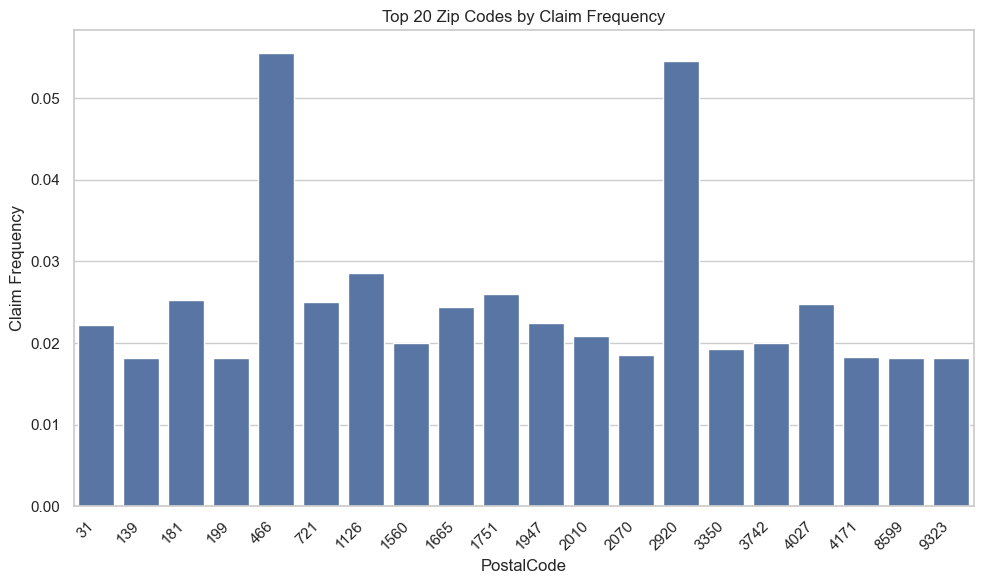

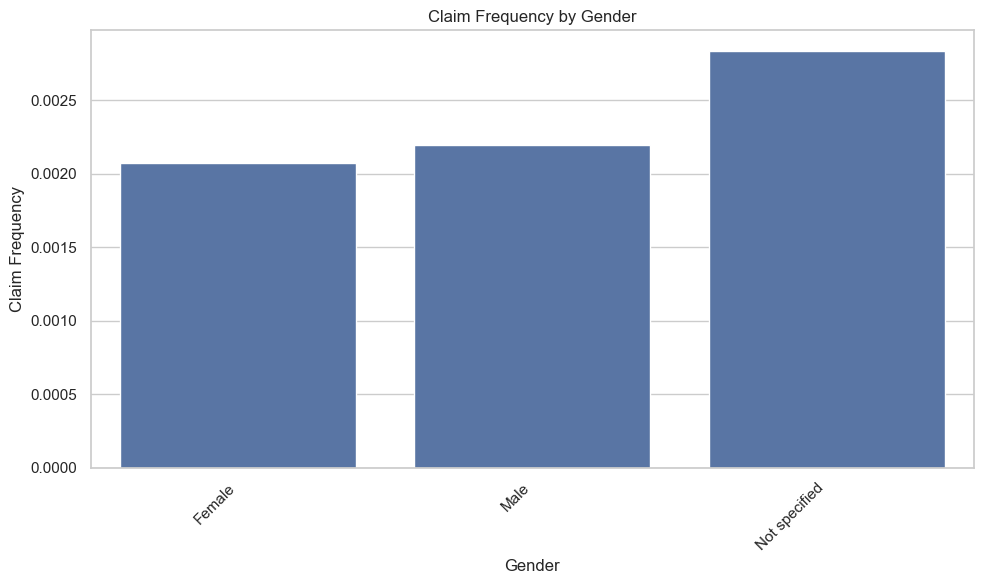

In [21]:
# PostalCode
plot_top_zipcode_frequency(df, top_n=20)

# Gender
plot_claim_frequency_by_feature(df, "Gender")

In [10]:
#  Run hypothesis tests
hypotheses = [
    # Risk differences across provinces
    {"feature": "Province", "kpi": "ClaimFrequency", "test_type": "chi2", "description": "Claim frequency differences across provinces"},
    {"feature": "Province", "kpi": "ClaimSeverity", "test_type": "anova", "description": "Claim severity differences across provinces"},
    {"feature": "Province", "kpi": "Margin", "test_type": "anova", "description": "Margin differences across provinces"},

    # Risk differences across zip codes
    {"feature": "PostalCode", "kpi": "ClaimFrequency", "test_type": "chi2", "description": "Claim frequency differences across zip codes"},
    {"feature": "PostalCode", "kpi": "ClaimSeverity", "test_type": "anova", "description": "Claim severity differences across zip codes"},
    {"feature": "PostalCode", "kpi": "Margin", "test_type": "anova", "description": "Margin differences across zip codes"},

    # Risk differences by gender
    {"feature": "Gender", "kpi": "ClaimFrequency", "test_type": "chi2", "description": "Claim frequency differences by gender"},
    {"feature": "Gender", "kpi": "ClaimSeverity", "test_type": "anova", "description": "Claim severity differences by gender"},
    {"feature": "Gender", "kpi": "Margin", "test_type": "anova", "description": "Margin differences by gender"}
]

results = run_hypothesis_tests(df, hypotheses)
results

d:\10Acadamy\Week 3\Tasks\Predictive-Modeling\.venv\Lib\site-packages\insurance_analytics\hypothesis\statistical_tests.py:53: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  F_stat, p_value = stats.f_oneway(*groups)


,feature,kpi,test_type,statistic,p_value,reject_null,description
0,Province,ClaimFrequency,chi2,104.190881,5.925511e-19,True,Claim frequency differences across provinces
1,Province,ClaimSeverity,anova,4.830166,6.304917e-06,True,Claim severity differences across provinces
2,Province,Margin,anova,3.222613,1.145008e-03,True,Margin differences across provinces
3,PostalCode,ClaimFrequency,chi2,1454.467610,3.152172e-30,True,Claim frequency differences across zip codes
4,PostalCode,ClaimSeverity,anova,NaN,NaN,False,Claim severity differences across zip codes
5,PostalCode,Margin,anova,0.870747,9.976860e-01,False,Margin differences across zip codes
6,Gender,ClaimFrequency,chi2,7.255926,2.657025e-02,True,Claim frequency differences by gender
7,Gender,ClaimSeverity,anova,2.411104,8.990443e-02,False,Claim severity differences by gender
8,Gender,Margin,anova,0.311618,7.322610e-01,False,Margin differences by gender


In [11]:
for idx, row in results.iterrows():
    if row['reject_null']:
        print(f"Reject H0 for {row['feature']} on KPI {row['kpi']}: p={row['p_value']:.4f}")
    else:
        print(f"Fail to reject H0 for {row['feature']} on KPI {row['kpi']}: p={row['p_value']:.4f}")


Reject H0 for Province on KPI ClaimFrequency: p=0.0000
Reject H0 for Province on KPI ClaimSeverity: p=0.0000
Reject H0 for Province on KPI Margin: p=0.0011
Reject H0 for PostalCode on KPI ClaimFrequency: p=0.0000
Fail to reject H0 for PostalCode on KPI ClaimSeverity: p=nan
Fail to reject H0 for PostalCode on KPI Margin: p=0.9977
Reject H0 for Gender on KPI ClaimFrequency: p=0.0266
Fail to reject H0 for Gender on KPI ClaimSeverity: p=0.0899
Fail to reject H0 for Gender on KPI Margin: p=0.7323
